<a href="https://colab.research.google.com/github/pritul2/Detection-of-Person-With-or-Without-Mask/blob/master/Classfication_of_Person_with_or_without_Wearing_Mask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install onnx==1.6.0
!pip install onnx-tf==1.3.0
!pip install onnxruntime==0.5.0
!pip install opencv-python==4.1.1.26
!pip install tensorflow==1.13.1

     |████████████████████████████████| 4.8MB 2.8MB/s 
     |████████████████████████████████| 122kB 2.7MB/s 
     |████████████████████████████████| 3.2MB 89kB/s 
     |████████████████████████████████| 28.7MB 157kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30


     |████████████████████████████████| 92.5MB 88kB/s 
     |████████████████████████████████| 368kB 42.2MB/s 
     |████████████████████████████████| 3.2MB 36.0MB/s 
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Found existing installation: tensorboard 2.2.1
    Uninstalling tensorboard-2.2.1:
      Successfully uninstalled tensorboard-2.2.1
  Found existing installation: tensorflow 2.2.0rc3
    Uninstalling tensorflow-2.2.0rc3:
      Successfully uninstalled tensorflow-2.2.0rc3


In [0]:
import cv2
from keras.models import load_model
import onnx
import onnxruntime as ort
from onnx_tf.backend import prepare
import numpy as np

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [0]:
def area_of(left_top, right_bottom):
    """
    Compute the areas of rectangles given two corners.
    Args:
        left_top (N, 2): left top corner.
        right_bottom (N, 2): right bottom corner.
    Returns:
        area (N): return the area.
    """
    hw = np.clip(right_bottom - left_top, 0.0, None)
    return hw[..., 0] * hw[..., 1]

def iou_of(boxes0, boxes1, eps=1e-5):
    """
    Return intersection-over-union (Jaccard index) of boxes.
    Args:
        boxes0 (N, 4): ground truth boxes.
        boxes1 (N or 1, 4): predicted boxes.
        eps: a small number to avoid 0 as denominator.
    Returns:
        iou (N): IoU values.
    """
    overlap_left_top = np.maximum(boxes0[..., :2], boxes1[..., :2])
    overlap_right_bottom = np.minimum(boxes0[..., 2:], boxes1[..., 2:])

    overlap_area = area_of(overlap_left_top, overlap_right_bottom)
    area0 = area_of(boxes0[..., :2], boxes0[..., 2:])
    area1 = area_of(boxes1[..., :2], boxes1[..., 2:])
    return overlap_area / (area0 + area1 - overlap_area + eps)

def hard_nms(box_scores, iou_threshold, top_k=-1, candidate_size=200):
    """
    Perform hard non-maximum-supression to filter out boxes with iou greater
    than threshold
    Args:
        box_scores (N, 5): boxes in corner-form and probabilities.
        iou_threshold: intersection over union threshold.
        top_k: keep top_k results. If k <= 0, keep all the results.
        candidate_size: only consider the candidates with the highest scores.
    Returns:
        picked: a list of indexes of the kept boxes
    """
    scores = box_scores[:, -1]
    boxes = box_scores[:, :-1]
    picked = []
    indexes = np.argsort(scores)
    indexes = indexes[-candidate_size:]
    while len(indexes) > 0:
        current = indexes[-1]
        picked.append(current)
        if 0 < top_k == len(picked) or len(indexes) == 1:
            break
        current_box = boxes[current, :]
        indexes = indexes[:-1]
        rest_boxes = boxes[indexes, :]
        iou = iou_of(
            rest_boxes,
            np.expand_dims(current_box, axis=0),
        )
        indexes = indexes[iou <= iou_threshold]

    return box_scores[picked, :]

def predict(width, height, confidences, boxes, prob_threshold, iou_threshold=0.5, top_k=-1):
    """
    Select boxes that contain human faces
    Args:
        width: original image width
        height: original image height
        confidences (N, 2): confidence array
        boxes (N, 4): boxes array in corner-form
        iou_threshold: intersection over union threshold.
        top_k: keep top_k results. If k <= 0, keep all the results.
    Returns:
        boxes (k, 4): an array of boxes kept
        labels (k): an array of labels for each boxes kept
        probs (k): an array of probabilities for each boxes being in corresponding labels
    """
    boxes = boxes[0]
    confidences = confidences[0]
    picked_box_probs = []
    picked_labels = []
    for class_index in range(1, confidences.shape[1]):
        probs = confidences[:, class_index]
        mask = probs > prob_threshold
        probs = probs[mask]
        if probs.shape[0] == 0:
            continue
        subset_boxes = boxes[mask, :]
        box_probs = np.concatenate([subset_boxes, probs.reshape(-1, 1)], axis=1)
        box_probs = hard_nms(box_probs,
           iou_threshold=iou_threshold,
           top_k=top_k,
           )
        picked_box_probs.append(box_probs)
        picked_labels.extend([class_index] * box_probs.shape[0])
    if not picked_box_probs:
        return np.array([]), np.array([]), np.array([])
    picked_box_probs = np.concatenate(picked_box_probs)
    picked_box_probs[:, 0] *= width
    picked_box_probs[:, 1] *= height
    picked_box_probs[:, 2] *= width
    picked_box_probs[:, 3] *= height
    return picked_box_probs[:, :4].astype(np.int32), np.array(picked_labels), picked_box_probs[:, 4]

In [0]:
cnt = 1
coords=[]
image_list=[]
def detect_face(image):
  global cnt
  #image = cv2.imread("/content/without_mask2/43400a0296ce70883f285009111c8524.jpg") #Changes done here#
  image = cv2.resize(image,(640,480))
  #plt.imshow(image)
  #plt.show()
  img = image.copy()
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img_mean = np.array([127, 127, 127])
  img = (img - img_mean) / 128
  img = np.transpose(img, [2, 0, 1])
  img = np.expand_dims(img, axis=0)
  img = img.astype(np.float32)
  onnx_model = onnx.load('/content/drive/My Drive/Copy of ultra_light_640.onnx')
  predictor = prepare(onnx_model)
  ort_session = ort.InferenceSession('/content/drive/My Drive/Copy of ultra_light_640.onnx')
  input_name = ort_session.get_inputs()[0].name
  confidences, boxes = ort_session.run(None, {input_name: img})
  h,w,_ = image.shape
  #print(boxes)
  boxes, labels, probs = predict(w, h, confidences, boxes, 0.7)
  cnt=0
  for i in range(boxes.shape[0]):
        print(predict)
        if probs[cnt]>0.99:
          box = boxes[i, :]
          x1, y1, x2, y2 = box
          #print(x1, y1, x2, y2)
          #cv2.rectangle(image, (x1, y1-5), (x2, y2+5), (80,18,236), 2)
          #cv2.rectangle(image, (x1, y2), (x2, y2), (80,18,236), 2)
          #print(image,type(image),image.shape,)
          #input()
          crop_image = image[y1:y2,x1:x2]
          if crop_image.shape[0]<=0 or crop_image.shape[1]<=0 or len(crop_image)==0:
            print("unable to crop image")
            continue
          '''image = cv2.resize(image,(256,256))
          print(image.shape)
          path = "/content/withmask"+str(cnt)+".png"
          cv2.imwrite(path,image)
          cnt+=1'''
          coords.append((x1,y1,x2,y2))
          image_list.append(crop_image)
          #print("sending")
        cnt+=1
  return coords,image_list

In [0]:
model = load_model('/content/drive/My Drive/vgg_mask.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


/usr/local/lib/python3.6/dist-packages/onnx_tf/common/handler_helper.py:37: UserWarning: Unknown op ConstantFill in domain `ai.onnx`.
  handler.ONNX_OP, handler.DOMAIN or "ai.onnx"))
/usr/local/lib/python3.6/dist-packages/onnx_tf/common/handler_helper.py:37: UserWarning: Unknown op ImageScaler in domain `ai.onnx`.
  handler.ONNX_OP, handler.DOMAIN or "ai.onnx"))
/usr/local/lib/python3.6/dist-packages/onnx_tf/common/handler_helper.py:34: UserWarning: Fail to get since_version of IsInf in domain `` with max_inclusive_version=9. Set to 1.
  handler.ONNX_OP, handler.DOMAIN, version))
/usr/local/lib/python3.6/dist-packages/onnx_tf/common/handler_helper.py:34: UserWarning: Fail to get since_version of Mod in domain `` with max_inclusive_version=9. Set to 1.
  handler.ONNX_OP, handler.DOMAIN, version))
/usr/local/lib/python3.6/dist-packages/onnx_tf/common/handler_helper.py:34: UserWarning: Fail to get since_version of ThresholdedRelu in domain `` with max_inclusive_version=9. Set to 1.
  hand

<function predict at 0x7f876b394d90>
<function predict at 0x7f876b394d90>
74 107 162 256


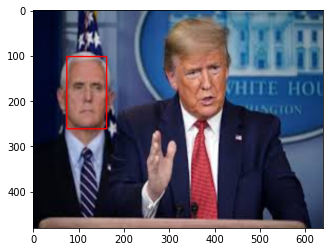

317 72 422 231


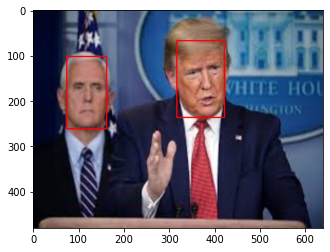

In [0]:
import matplotlib.pyplot as plt
img = cv2.imread("/content/images.jpeg")
original_img = img.copy()
box,img_list = detect_face(img)
for images,b in zip(img_list,box):
  images = cv2.cvtColor(images,cv2.COLOR_RGB2BGR)

  images = cv2.resize(images,(224,224))
  images = images/255.0
  pred = model.predict(images[np.newaxis,...])
  flag=0
  if pred[0][0]<pred[0][1]:
    flag=1
  if flag==0:
    x1, y1, x2, y2 = b
    '''if abs(y1-y2)>70:
      continue'''
    print(x1, y1, x2, y2)
    original_img = cv2.resize(original_img,(640,480))
    cv2.rectangle(original_img, (x1, y1-5), (x2, y2+5), (0,255,0), 2)
  else:
    x1, y1, x2, y2 = b
    '''if abs(y1-y2)>70 :
      continue'''
    print(x1, y1, x2, y2)
    original_img = cv2.resize(original_img,(640,480))
    cv2.rectangle(original_img, (x1, y1-5), (x2, y2+5), (0,0,255), 2)

  plt.imshow(cv2.cvtColor(original_img,cv2.COLOR_RGB2BGR))
  plt.show()